## Contradictory, My Dear Watson

### Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import sentencepiece
import tensorflow as tf
from transformers import XLMRobertaTokenizer, BertTokenizer, TFBertModel, TFXLMRobertaModel

2024-07-02 14:44:31.425698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 14:44:31.425808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 14:44:31.580695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [3]:
df_train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
df_test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


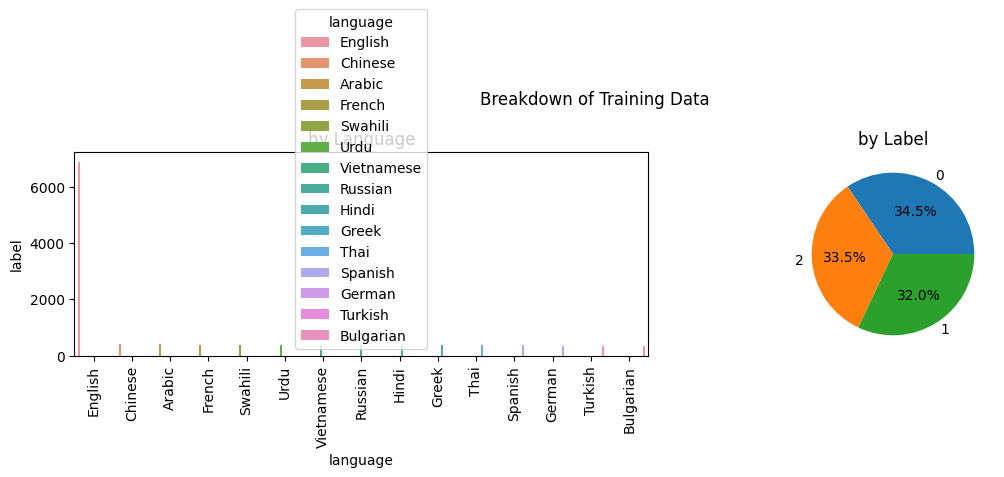

In [4]:
fig, axs = plt.subplots(figsize= (12,4), ncols= 2, nrows= 1)

dt_language = df_train.groupby("language")['label'].count().sort_values(ascending= False).reset_index()
# dt_language.loc[dt_language.label < (0.03*df_train.shape[0]), "language"] = "Other"
# dt_language = dt_language.groupby("language")['label'].sum().sort_values(ascending= False).reset_index()
sns.barplot(data= dt_language, x= "language", y= "label", hue= "language", ax= axs[0])
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
axs[0].set_title("by Language")

axs[1].pie(df_train["label"].value_counts(), autopct='%1.1f%%', labels= df_train["label"].value_counts().index);
axs[1].set_title("by Label")

plt.suptitle("Breakdown of Training Data");
plt.tight_layout();

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')

In [6]:
# setting up a TPU
# TODO: connect to a cloud TPU later. Currently, generates error and uses CPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [7]:
# model_name = 'bert-base-multilingual-cased'
model_name = 'jplu/tf-xlm-roberta-large'
model_name = 'xlm-roberta-base'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [8]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

encode_sentence("I love machine learning!")

[87, 5161, 36279, 52080, 38, 3]

In [9]:
import numpy as np
max_len= 200
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor()[:,:max_len],
      'input_mask': input_mask[:,:max_len],
      'input_type_ids': input_type_ids[:,:max_len]}

  return inputs

In [10]:
train_input = bert_encode(df_train.premise.values, df_train.hypothesis.values, tokenizer)
test_input = bert_encode(df_test.premise.values, df_test.hypothesis.values, tokenizer)

In [11]:
def build_model():
    bert_encoder = TFXLMRobertaModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    
    maxpool = tf.keras.layers.GlobalAveragePooling1D(name= 'maxpool')(embedding)
    output = tf.keras.layers.Dense(3, activation='softmax')(maxpool)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
with strategy.scope():
    model = build_model()
    model.summary()

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 200)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                              

In [ ]:
history = model.fit(train_input, df_train.label.values, epochs = 5, verbose = 1, 
                    batch_size = 64, validation_split = 0.2)

Epoch 1/5


In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
df_test['pred_label'] = predictions
df_test.head()

In [ ]:
submission = df_test.id.copy().to_frame()
submission['prediction'] = predictions
submission.head()

In [ ]:
submission.to_csv("submission.csv", index = False)